# Automatic prompt generation  for `text-to-image` tasks using a CNN scorer

This notebook contains an example of a simple genetic algorithm that using Gemini mutate prompts to improve the quality of image generated by `text-to-image` models

# 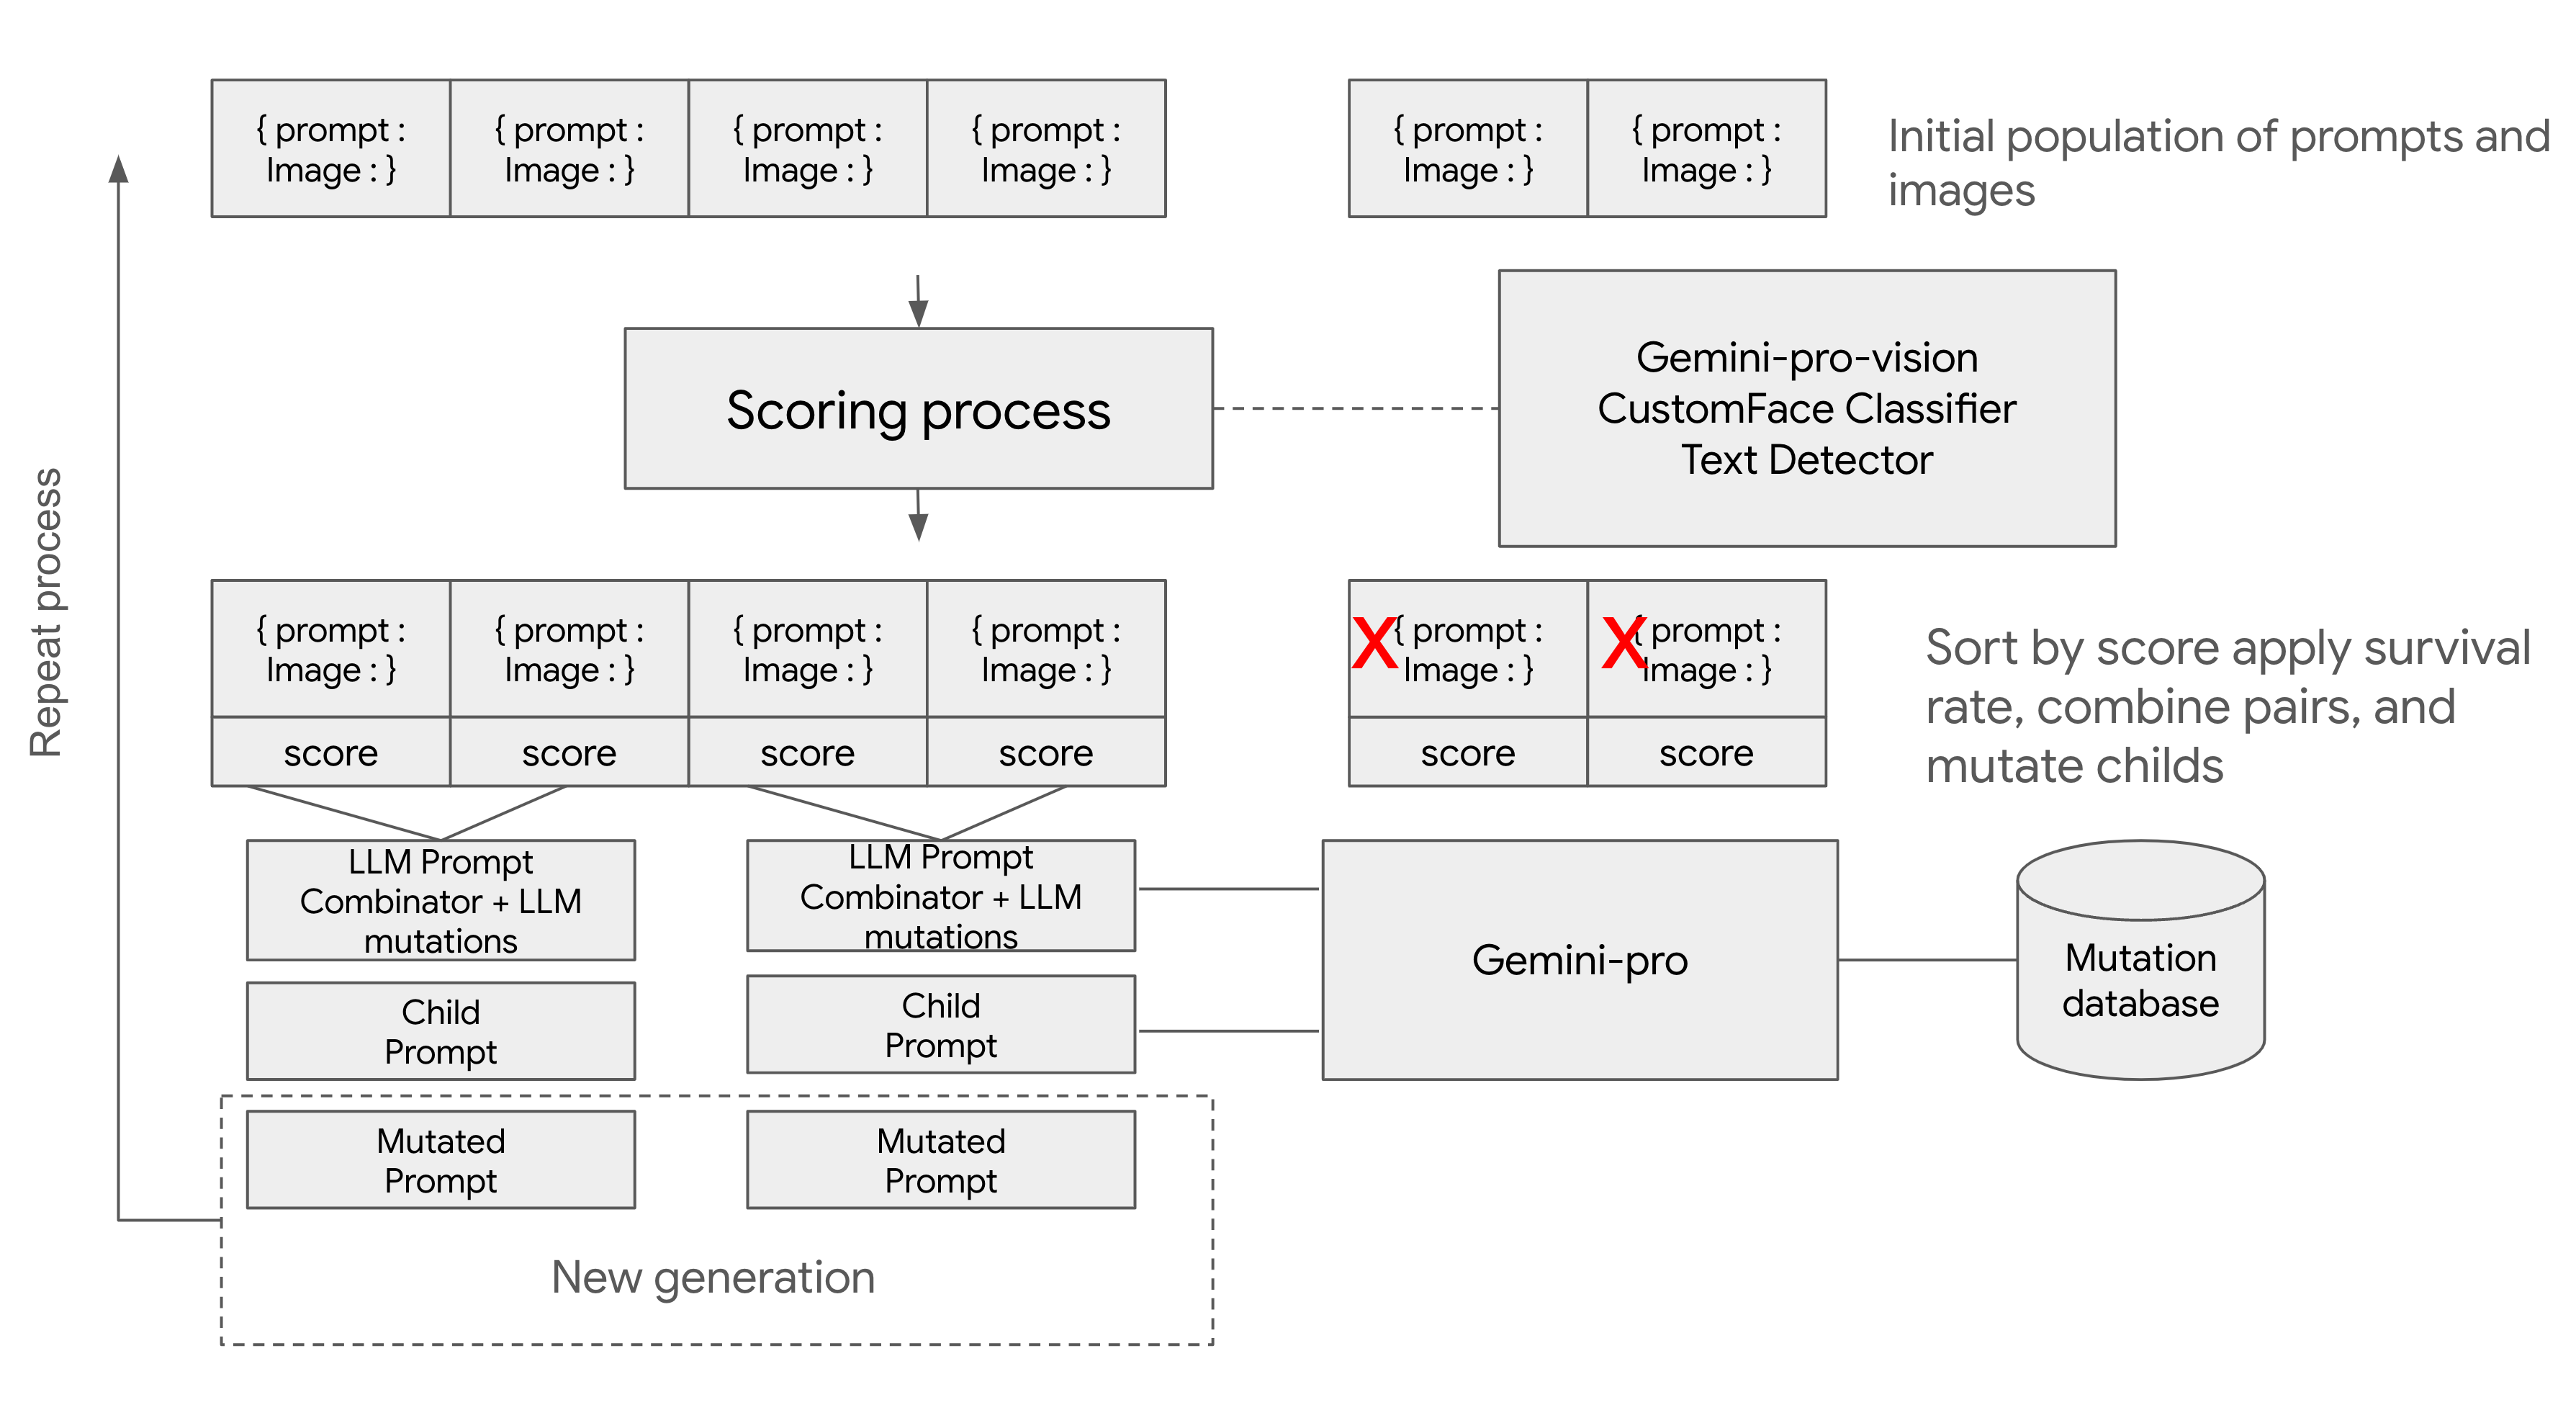

In [ ]:
!pip install google-cloud-vision

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [ ]:
from PIL import Image
import random
import ast
import io
import logging
import requests
import numpy as np
import json
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2
import os
import base64
import google.auth
from google.cloud import vision
from vertexai.preview.generative_models import GenerativeModel,GenerationConfig
from vertexai.preview import generative_models

 ## Face quality classifier model

In [ ]:
NUM_EPOCHS = 10
TRAIN_DIR = "data/faces/train/"
VAL_DIR = "data/faces/val/"
CLASS_GOOD_FACES = "good_faces"
CLASS_BAD_FACES = "bad_faces"
OUTPUT_MODEL_DIR = "cnn_model_faces"
LR = 0.01

PROJECT_ID = "${project_id}"
LOCATION = "us-central1"
IMAGEN_MODEL = "imagegeneration@005"
MAX_SEED = 1000000

In [ ]:
logging.getLogger().setLevel(logging.INFO)
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_QUOTA_PROJECT"] = PROJECT_ID
os.makedirs(os.path.join(TRAIN_DIR,CLASS_GOOD_FACES), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR,CLASS_BAD_FACES), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR,CLASS_GOOD_FACES), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR,CLASS_BAD_FACES), exist_ok=True)
os.makedirs(OUTPUT_MODEL_DIR, exist_ok=True)

In [ ]:
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/train/good_faces/* data/faces/train/good_faces/
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/train/bad_faces/ data/faces/train/bad_faces/
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/val/good_faces/* data/faces/val/good_faces/
! gcloud storage cp gs://data-analytics-golden-demo/data-beans/v1/colab-supporting-images/face_examples/faces/val/bad_faces/ data/faces/val/bad_faces/

In [ ]:
class FaceClassifierConvNet(nn.Module):
    def __init__(self, num_classes):
        super(FaceClassifierConvNet, self).__init__()
        self.num_classes = num_classes
        self.layer1 = self.conv_module(3, 16)
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(256, self.num_classes)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, self.num_classes)
        return out
    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomRotation(degrees=30),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229,0.224,0.225]),
])
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229,0.224,0.225]),
])

class TrainDataset(Dataset):
    def __init__(self, train_dir):
        self.foldernames = [name for name in os.listdir(train_dir)]
        self.data = []
        for label in self.foldernames:
            for file in os.listdir(train_dir+label):
                self.data.append([train_dir+label+"/"+file,label])
        self.classmap ={element: index for index, element in enumerate(self.foldernames)}
        self.img_dim = (224,224)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.classmap[class_name]
        img_tensor = train_transform(img)
        class_id = torch.tensor(class_id)
        return img_tensor, class_id

class ValDataset(Dataset):
    def __init__(self, val_dir):
        self.foldernames = [name for name in os.listdir(val_dir)]
        self.data = []
        for label in self.foldernames:
            for file in os.listdir(val_dir+label):
                self.data.append([val_dir+label+"/"+file,label])
        self.classmap ={element: index for index, element in enumerate(self.foldernames)}
        self.img_dim = (224,224)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.classmap[class_name]
        img_tensor = val_transform(img)
        class_id = torch.tensor(class_id)
        return img_tensor, class_id

In [ ]:
train_data = TrainDataset(TRAIN_DIR)
val_data = ValDataset(VAL_DIR)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )
model = FaceClassifierConvNet(num_classes=2).to(device, non_blocking=True)

dataLoaders = {
    "train": DataLoader(train_data, batch_size = 16, shuffle=True),
    "valid": DataLoader(val_data, batch_size = 16, shuffle=True),
}

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def save_model(model, epoch_num):
    save_filename = "net_%s.pth"%epoch_num
    save_path=os.path.join(OUTPUT_MODEL_DIR,save_filename)
    torch.save(model.cpu().state_dict(), save_path)


for epoch in range(NUM_EPOCHS):
    logging.info(f"Epoch no:  {epoch}")
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataLoaders["train"]:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item()* inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    exp_lr_scheduler.step()
    epoch_loss = running_loss/len(train_data)
    epoch_acc = running_corrects.double()/len(train_data)
    logging.info(f'loss :{epoch_loss} , acc {epoch_acc}')
    if (epoch%5 == 0):
        save_model(model,epoch)

## Genetic Algorithm

In [ ]:
MUTATION_DATABASE = [
    "",
    "dramatic lighting",
    "blurred background",
    "taken by a professional photographer",
    "DSLR style",
    "using high shutter speed",
    "photorealistic",
    "full body picture",
    "half body picture"
    "taken from a low-angle viewpoint",
    "4K resolution",
    "8K resolution",
    "studio photo",
]

In [ ]:
def show_image(image):
    return Image.open(io.BytesIO(image))

In [ ]:
def _get_folder_names(directory):
    folder_names = []
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            folder_names.append(dir_name)
    return folder_names

def predict_face_quality(image):
    logging.info("Predicting face quality ...")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )
    model = FaceClassifierConvNet(num_classes=2).to(device, non_blocking=True)
    model.load_state_dict(torch.load("cnn_model_faces/net_5.pth", map_location=torch.device('cpu')))

    predict_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229,0.224,0.225]),
    ])

    class_label = _get_folder_names("data/faces/train/")
    image_array = np.array(image)
    img = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (224,224))
    trans_img = predict_transform(img)
    trans_img = trans_img.unsqueeze(0)
    model.eval()
    outputs = model(trans_img)
    _, preds = torch.max(outputs,1)
    text = class_label[preds[0]]
    logging.info(f"Face quality is: {text}")
    return text

In [ ]:
def _detect_faces(content):
    logging.info("Checking if the image has any faces ...")
    client = vision.ImageAnnotatorClient()
    image = vision.Image(content=content)
    return client.face_detection(image=image).face_annotations


def _detect_text(content):
    logging.info("Checking if the image has any text ...")
    client = vision.ImageAnnotatorClient()
    image = vision.Image(content=content)
    return client.text_detection(image=image).text_annotations

def _crop_faces(image_bytes):
    nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    face_detections = _detect_faces(image_bytes)
    cropped_faces = []
    for face in face_detections:
        vertices = face.bounding_poly.vertices
        x0 = round(vertices[0].x)
        y0 = round(vertices[0].y)
        x1 = round(vertices[2].x)
        y1 = round(vertices[2].y)
        crop = image[y0:y1, x0:x1]
        cropped_faces.append(Image.fromarray(crop))
    return cropped_faces


def _gen_image(prompt):
    logging.info(f"Generating image with prompt: {prompt} ...")
    creds, project = google.auth.default()
    auth_req = google.auth.transport.requests.Request()
    creds.refresh(auth_req)
    project = PROJECT_ID
    location = LOCATION
    model_id = IMAGEN_MODEL
    access_token = creds.token
    parameters = {"seed": random.randint(1, MAX_SEED),"sampleCount": 1,"aspectRatio": "1:1","outputOptions": {"mimeType": "image/png"}}
    payload = {"instances": [{"prompt": prompt}],"parameters": parameters}
    headers = {"Content-Type": "application/json","Authorization": "Bearer " + access_token}
    url = f"https://{location}-aiplatform.googleapis.com/v1/projects/{project}/locations/{location}/publishers/google/models/{model_id}:predict"
    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200 and 'predictions' in json.loads(response.content):
        image_data = json.loads(response.content)["predictions"][0]["bytesBase64Encoded"]
        image_data = base64.b64decode(image_data)
        return image_data
    else:
        #empty image
        return Image.new("RGB", (800, 1280), (255, 255, 255))


In [ ]:
def _llm_evaluator(images,criteria):
    example_return_json='[ {"rating" : 10, "explanation": ""}]'
    eval_prompt=f"""
        You are a expert human photo reviewer.
        You are going to be presented with {len(images)}.
        You must critique each image and assign it a score from 1 to 100.
        You should compare the images to one another.
        You should evaluate each image multiple times.

        Score each image based upon the following:
        {criteria}

        Think the rating through step by step for each image.

        Place the result of the scoring process in the "rating" field.
        Explain your reasoning and place in the "explanation" field in less than 20 words.

        Place the results in the following JSON structure:
        {example_return_json}
        """
    gemini_pro_vision_model = GenerativeModel("gemini-pro-vision")
    parts = [eval_prompt]
    for image in images:
        part = generative_models.Part.from_data(image,mime_type="image/png")
        parts.append(part)
    generation_config = GenerationConfig(
        temperature=0,
        top_p=1.0,
        top_k=32,
        candidate_count=1)
    model_response = gemini_pro_vision_model.generate_content(parts,generation_config=generation_config)
    response = ast.literal_eval(model_response.candidates[0].content.parts[0].text)
    logging.info(f"len of images is {len(images)} and len of response is {len(response)}" )
    return response

In [ ]:
def _combine_promtps(prompts):
    logging.info(f"Combining prompts: {prompts} ...")
    if len(prompts) > 2:
        combine_prompt=f"""You are a genetic algorithm, trying to create the best prompt
            for image generation. You need to create a new prompt based on the breeding of {len(prompts)}
            Combine all the prompts and generate a new one.
            Prompts to combine/breed are : {prompts}
            """
        model = GenerativeModel("gemini-pro")
        generation_config = GenerationConfig(
            temperature=0,
            top_p=1.0,
            top_k=32,
        candidate_count=1)
        response = model.generate_content(combine_prompt).candidates[0].content.parts[0].text
        logging.info(f"Combined prompt is {response}")
        return response
    else:
        logging.info(f"Combined prompt is {prompts[0]}")
        return prompts[0]

def _mutate_prompt(prompt):

    logging.info(f"Mutating prompt: {prompt} ...")
    mutation = random.choice(MUTATION_DATABASE)
    logging.info(f"Mutation selected is : {mutation} ...")
    if  mutation:
        mutate_prompt=f"""You are a genetic algorithm, trying to create the best prompt
            for image generation. You need to mutate a existing prompt with a change.
            Return a new prompt that is similar to the original one but adding the change.
            Original prompt is : {prompt}
            Mutation change is: {mutation}
            Only add the mutation change and nothing more
            """
        model = GenerativeModel("gemini-pro")
        generation_config = GenerationConfig(
            temperature=0,
            top_p=1.0,
            top_k=32,
        candidate_count=1)
        response = model.generate_content(mutate_prompt).candidates[0].content.parts[0].text
        logging.info(f"Mutated prompt is {response}")
        return response
    else:
        logging.info(f"Mutated prompt is {prompt}")
        return prompt

In [ ]:
def score_population(population_list,criteria):
    logging.info(f"Scoring population ...")
    images = []
    for population_item in population_list:
        images.append(population_item['image'])
    llm_evaluator_response = _llm_evaluator(images,criteria)
    for index,image in enumerate(images):
        has_faces = len(_detect_faces(image))
        has_text = len(_detect_text(image))
        if has_faces:
            faces = _crop_faces(population_item['image'])
            for face in faces:
                if predict_face_quality(face) == "bad_faces":
                    llm_evaluator_response[index]['rating'] = llm_evaluator_response[index]['rating'] - 10
                else:
                    llm_evaluator_response[index]['rating'] = llm_evaluator_response[index]['rating'] + 10
        if has_text:
            llm_evaluator_response[index]['rating'] = llm_evaluator_response[index]['rating'] - 5
        logging.info(f"Adding score of {llm_evaluator_response[index]['rating']}")
        population_list[index].update({"score": llm_evaluator_response[index]['rating']})
    return population_list

In [ ]:
def generate_initial_population(base_prompt,population_size,criteria):
    logging.info(f"Generating initial population with base prompt: {base_prompt} and size of : {population_size}")
    population_list = []
    population_item = {}
    population_item['prompt'] = base_prompt
    population_item['image'] = _gen_image(base_prompt)
    population_list.append(population_item)
    for _ in range(population_size):
        population_item = {}
        prompt = random.choice(population_list)['prompt']
        mutated_prompt = _mutate_prompt(prompt)
        population_item['prompt'] = mutated_prompt
        population_item['image'] = _gen_image(mutated_prompt)
        population_list.append(population_item)
    population_list = score_population(population_list,criteria)
    return population_list

In [ ]:
def get_best_score(population):
    logging.info(f"Getting best item on population ...")
    highest_score_item = max(population, key=lambda x: x.get('score', 0))
    logging.info(f"Best score is {highest_score_item['score']}")
    return highest_score_item

In [ ]:
def apply_survival(population,survival_rate):
    logging.info(f"Applying survival rate of {survival_rate} ...")
    num_to_keep = int(len(population) * survival_rate)
    logging.info(f"Eliminating {len(population)-num_to_keep} items ...")
    sorted_population = sorted(population, key=lambda x: x.get('score', 0), reverse=True)
    survived_population = sorted_population[:num_to_keep]
    return survived_population

In [ ]:
def calculate_next_generation(population,criteria):
    logging.info(f"Calculating next generation ...")
    children_list = []
    for i in range(0, len(population) - 1, 2):
        children = {}
        children_prompt = _combine_promtps([population[i]['prompt'], population[i+1]['prompt']])
        children_prompt = _mutate_prompt(children_prompt)
        children_image = _gen_image(children_prompt)
        children['prompt'] = children_prompt
        children['image'] = children_image
        children_list.append(children)
    if len(population) % 2 == 0:
        last_child = {}
        last_child_prompt = population[-1]['prompt']
        last_child_prompt = _mutate_prompt(last_child_prompt)
        last_child_image = _gen_image(last_child_prompt)
        last_child['prompt'] = last_child_prompt
        last_child['image'] = last_child_image
        children_list.append(last_child)
    children_list = score_population(children_list,criteria)
    return children_list

In [ ]:
def gen_alg_imagen(base_prompt,population_size,generations,survival_rate,criteria):
    population = generate_initial_population(base_prompt,population_size,criteria)
    best_item = population[0]
    population_size = len(population)
    while (generations > 0 and population_size >= 2):
        population = apply_survival(population,survival_rate)
        population = calculate_next_generation(population,criteria)
        population_size = len(population)
        generations -= 1
        best_item = get_best_score(population)
        logging.info(f"Iteration completed - population size : {population_size} , remaining generations: {generations}" )
    return  best_item


In [ ]:
base_prompt="Image of a person having a coffe just bought from a coffee truck in the middle of a big city"
criteria = """
        - Ultra-Realistic images should get a high rating.
        - Detailed images hould get a high rating.
        - Plastic looking images should get a low rating.
        - Abstract images should get a low rating.
        - Non realistic images should get a low rating.
        - Be VERY conservative with the scoring, images with very high scores are only reserved for images that look just like reality.
"""
best_item = gen_alg_imagen(base_prompt=base_prompt,population_size=3,generations=2,survival_rate=0.8,criteria=criteria)

In [ ]:
print(f"Best image score is : {best_item['score']}")
print(f"Best prompt is : {best_item['prompt']}")
show_image(best_item['image'])

In [ ]:
print(f"Initial image is:")
show_image(_gen_image(base_prompt))